In [2]:
from src.utils import generate_csv_data
from src.shared import singleton_engine
from src.models import WordsEn
from src.models import GetWordEn
from sqlalchemy import text
from pathlib import Path
from dotenv import load_dotenv
from pprint import pprint

load_dotenv(dotenv_path=Path.cwd(), override=True)

False

In [3]:
# Might be my skill issue or kernel's chaos, but in notebook downloading is extremly slow, so don't use util for csv generation with preloaded_data=False here
generated_csv_path = generate_csv_data()

In [ ]:
%pip install nltk
import nltk
nltk.download('wordnet')

  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached regex-2025.9.18-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached regex-2025.9.18-cp311-cp311-win_amd64.whl (276 kB)
Using cached click-8.3.0-py3-none-any.whl (107 kB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/5 [tqdm]
   -------- ------------------------------- 1/5 [regex]
   ---------------- ----------------------- 2/5 [joblib]
   ---------------- ----------------------- 2/5 [joblib]
   ---------------- ----------------------- 2/5 [joblib]
   ---------------- ----------------------- 2/5 [joblib]
   ------------------------ --------------- 3/5 [click]
   -------------

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\W0RtHl3s\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('unlikeliest', 'a')

'unlikeliest'

As you can see, widespread WordNetLemmatizer solution cannot find correct form of word 'unlikeliest', but contexto can, so we should try smthn else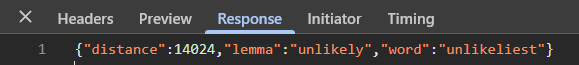

Next, it is better to run in terminal, not here, so:

```bash
pip uninstall gensim
pip uninstall numpy
pip uninstall scipy
pip install spacy
python -m spacy download en_core_web_lg
pip install spacy-lookups-data
```

If code below doesn't work, try restarting the current kernel

In [1]:
import spacy

model = spacy.load('en_core_web_lg')
model.remove_pipe("lemmatizer")
model.add_pipe("lemmatizer", config={"mode": "lookup"}).initialize()

word = model('unlikeliest')

for token in word:
    print(token.lemma_)


unlikely


In [2]:
cat_token = model('cat')[0]
dog_token = model('dog')[0]
kitten_token = model('kitten')[0]

print(cat_token.similarity(dog_token))
print(cat_token.similarity(kitten_token))

0.8016854524612427
0.8215553164482117


In [4]:
# Used single time for creating extension, table, index and copying data from generated .csv file
with singleton_engine.connect() as conn:
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    creation_query = """
                        CREATE TABLE words_en (
                        id UUID DEFAULT gen_random_uuid() PRIMARY KEY,
                        word varchar(20) NOT NULL,
                        embedding vector(300) 
                        );
                        CREATE INDEX ON words_en USING hnsw (embedding vector_cosine_ops);
                     """
    conn.execute(text(creation_query))
    copy_query = f"""
                    COPY words_en (word, embedding) FROM '{generated_csv_path}' DELIMITER ',' CSV;
                 """
    conn.execute(text(copy_query))
    conn.commit()

In [5]:
# Test query to verify everything works smoothly
def test_cosine_similarity(word: str, limit: int) -> list[GetWordEn]:
    with singleton_engine.connect() as conn:
        test_query = f"""
                        SELECT word, 1 - (embedding <=> (SELECT embedding from words_en WHERE word = :word)) as distance
                        FROM words_en
                        ORDER BY distance DESC
                        LIMIT :limit;
                     """
        result = conn.execute(text(test_query), {"word": word, "limit": limit}).all()
    similar_words = []
    for row in result:
        similar_words.append(GetWordEn(word=row[0], distance=row[1]))
    
    return similar_words

pprint(test_cosine_similarity(word='woman', limit=10))

[GetWordEn(word='woman', distance=1.0),
 GetWordEn(word='man', distance=0.7664013747067495),
 GetWordEn(word='girl', distance=0.7494641774911672),
 GetWordEn(word='teenager', distance=0.631708604958935),
 GetWordEn(word='lady', distance=0.6288786571651082),
 GetWordEn(word='mother', distance=0.6076306670085915),
 GetWordEn(word='policewoman', distance=0.6069462721551703),
 GetWordEn(word='boy', distance=0.5975908768400086),
 GetWordEn(word='she', distance=0.5641393359770321),
 GetWordEn(word='person', distance=0.5470173400209332)]
